# Extract Features

Neste notebook é realizada a extração de _features_ do _Speech Database_ + _Data Augmented_. É utilizado um extrator de MFCCs para elaborar um _dataset_ a partir dos arquivos de fala.
São utilizados os ponteiros gerados no _notebook_ **SpeechDatabase.ipynb** para realizar a extração, sendo que o centro dos _frames_ processados é a localizado na posição do respectivo ponteiro.

Os principais parâmetros utilizados na extração estão situados no arquivo python __envparams.py__.

## Importação das bibliotecas  

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

from scipy.io.wavfile import read as wavread
from scipy.io.wavfile import write as wavwrite

from utils import utils
from utils.wav import wavinfo
# from utils.wavfile import read as wavread
from utils.envparams import *

import os

## Definição dos PATHs

In [2]:
PATH_root = '..'

PATH_speechDB = os.path.join(PATH_root, 'SpeechDatabase')
PATH_ptVoices = os.path.join(PATH_speechDB, 'newPortugueseVoicesDB')
PATH_pt8k     = os.path.join(PATH_ptVoices, 'wav8k_files')
PATH_pt48k     = os.path.join(PATH_ptVoices, 'wav48k_files')
PATH_noise    = os.path.join(PATH_speechDB, 'soundNoise')


PATH_results         = 'results'
PATH_resultsSpeechDB = os.path.join(PATH_results, 'SpeechDatabase')
PATH_resultsDataaug  = os.path.join(PATH_results, 'DataAugmentation')
PATH_resultsExtFeat  = os.path.join(PATH_results, 'ExtractFeatures')
PATH_ExtFeatsamples  = os.path.join(PATH_resultsExtFeat, 'FrameSamples')
PATH_ExtFeatdicts    = os.path.join(PATH_resultsExtFeat, 'Dicionarios')

## Load Speech Database Dictionaries

Carrega os dicionários obtidos no _notebook_ **SpeechDatabase.ipynb**.

In [3]:
trainPt  = np.load(os.path.join(PATH_resultsSpeechDB, 'trainPt.npy')).item()
testPt   = np.load(os.path.join(PATH_resultsSpeechDB, 'testPt.npy')).item()
validPt  = np.load(os.path.join(PATH_resultsSpeechDB, 'validPt.npy')).item()
trainNoise = np.load(os.path.join(PATH_resultsSpeechDB, 'trainNoise.npy')).item()
testNoise  = np.load(os.path.join(PATH_resultsSpeechDB, 'testNoise.npy')).item()
validNoise = np.load(os.path.join(PATH_resultsSpeechDB, 'validNoise.npy')).item()

## Feature Extration

### Funções utilizadas

Abaixo são declaradas as duas funções de extração de atributos dos bancos de dados.
A função 
```python
def ExtractFeatureKW(args)
``` 
é utilizada para extrair do de todas as _keywords_ do banco de dados referente ao dicionário aplicado. 

A função 
```python
def ExtractFeatureOOV(args)
``` 
extrai OOVs dos arquivos de áudio OOV do dicionário. É estipulado um `pntrRate` que indica a taxa de ponteiros retirados de um arquivo de áudio. O número de ponteiros é variável com o tamanho do arquivo

Já a função
```python
def ExtractFeatureKWExpanse(args)
``` 
é utilizada para extrair atributos dos arquivos expandidos pelo **Data Augmentation**. 

Todas as funções citadas acima realizam _Data Augmentation_ através de _time shift_ e variação de amplitude. 


In [4]:
def ExtractFeatureKW(dictSet,
                          Amp_int=[0.5, 1.5], Amp_noise_int=[0.01, 0.1],
                          timeshift=500, Naugment=5, noise=None, 
                          proc=librosa.feature.mfcc,
                          namefile='nametosave', saveprob=0,
                          printby='label', print_ratio=10,
                          **kwargs):
    # imprime detalhes do processo
    print('Processando dicionário '+utils.whoisthis(dictSet)+' - keywords.\n')

    # define limites do save prob
    if saveprob < 0 or saveprob > 1:
        saveprob = 0
    
    # é salvo algo ou nao
    if saveprob==0:
        savefile=False
    else:
        savefile=True
        
    N=Naugment
    
    # define o sinal de ruído zero se não foi enviado sinal.
    if type(noise)!=np.ndarray:
        noise=np.zeros(20000)
    
    allframes = {}
    for i in range(nkw):
        allframes['kw'+str(i)] = []
        dictSet['kw'+str(i)+'Feat'] = []
    
    num = 0    

    # varre todos os arquivos do dicionário
    for i in range(len(dictSet['file'])):
        
        if dictSet['type'][i] != 'KW':
            continue
        # lê o arquivo de áudio
        wavstr = os.path.join(PATH_pt8k,dictSet['file'][i])
#         [_, data_file] = wavread(wavstr)
        data_file = utils.wavread(wavstr, fs)
        
        # normaliza amostras
        data_file = data_file/np.max(data_file)*0.5

        for kw in range(nkw):
            # inicializa listas utilizadas no proximo sweep
            framefile = []
            frameFeat = []
            
            # varre os ponteiros referentes aos arquivos de áudio
            for j in range(len(dictSet['kw'+str(kw)][i])):

                # se arquivo nao possuir ponteiro, nao continua
                if dictSet['kw'+str(kw)][i][j] < 0:
                    break
                    
                # configura ponteiro
                index = dictSet['kw'+str(kw)][i][j]/6

                # prepara o data augmented:
                # adquire valores aleatórios dentro dos intervalos de amplitude e deslocamento
                # RUIDO
                Anoise = utils.randomUniform(N, Amp_noise_int[1], Amp_noise_int[0])
                inoise = utils.randomUniform(N, len(noise)-frame_lenD2,frame_lenD2).astype(int)
                # AUDIO
                Aaudio = utils.randomUniform(N, Amp_int[1], Amp_int[0])
                ishift = utils.randomUniform(N, index+timeshift, index-timeshift).astype(int)

                # inicializa listas utilizadas no proximo sweep
                framelist = []
                Featlist = []

                # varre os N augmenting, realiza a extração de features
                # realiza o data augmentation
                for k in range(N):

                    # extrai frames ruido e audio com tamanho desejado
                    framenoise = Anoise[k]*utils.extract_frame(noise, inoise[k],
                                                frame_len=frame_len)
                    # ajusta deslocamento por alongamento realizado pelo time stretch
                    frameSample = Aaudio[k]*utils.extract_frame(data_file, ishift[k], 
                                                frame_len=frame_len)

                    # realiza a extração de features
                    FeatSample = proc(y=frameSample+framenoise, **kwargs)

                    # armazena no dicionario as features
                    dictSet['kw'+str(kw)+'Feat'].append(FeatSample[ofs_mfcc:])

                    # salva frame a partir da probabilidade de salvar
                    if savefile:
                        if utils.takeprob(saveprob):
                            frameSample[0] = 1
                            allframes['kw'+str(kw)].append(frameSample+framenoise)


        # imprime na tela o andamento
        if printby=='number':
            num += 1
            if num == print_ratio:
                print('File processed:', wavstr)
                num = 0
        elif printby=='label':
            print('File processed:', wavstr)

    print('\n')
    
    # salva o arquivo de frames sortidos
    if savefile:
        for kw in range(nkw):
            frames = np.vstack(allframes['kw'+str(kw)]).reshape(-1)
            if not os.path.isdir(PATH_ExtFeatsamples):
                os.makedirs(PATH_ExtFeatsamples)
            wavwrite(os.path.join(PATH_ExtFeatsamples, namefile+'kw'+str(kw)+'.wav'), fs, frames)


In [5]:
def ExtractFeatureOOV(dictSet,proc=librosa.feature.mfcc,root='',
                          Amp_int=[0.5, 1.5], pntrRate=1, 
                          namefile='nametosave', saveprob=0,
                          printby='label', print_ratio=10,
                          **kwargs):
    # imprime detalhes do processo
    print('Processando dicionário '+utils.whoisthis(dictSet)+' - OOVs.\n')

    # define limites do save prob
    if saveprob < 0 or saveprob > 1:
        saveprob = 0
    
    # é salvo algo ou nao
    if saveprob==0:
        savefile=False
    else:
        savefile=True
    
        
    allframes = []
    dictSet['oovFeat'] = []
    
    num = 0    

    # varre todos os arquivos do dicionário
    for i in range(len(dictSet['file'])):
        
        if dictSet['type'][i] != 'OOV':
            continue
        # lê o arquivo de áudio
        wavstr = os.path.join(root,dictSet['file'][i])
        data_file = utils.wavread(wavstr, fs)
        
        # normaliza amostras
        data_file = data_file/np.max(data_file)*0.5
        
        datalen = len(data_file)
        Npntrs  = int(np.round(datalen/frame_len*pntrRate))
        
        pntrs = utils.randomUniform(Npntrs, frame_lenD2, datalen-frame_lenD2).astype(int)
        
#         print(dictSet['file'][i])
#         print(datalen)
#         print(Npntrs)
#         print(pntrs)
#         break

        # inicializa listas utilizadas no proximo sweep
        framefile = []
        frameFeat = []
        
        # prepara o data augmented:
        # adquire valores aleatórios dentro dos intervalos de amplitude
        # AUDIO
        Aaudio = utils.randomUniform(Npntrs, Amp_int[1], Amp_int[0])

        # varre os ponteiros referentes aos arquivos de áudio
        for j in range(Npntrs):

            # inicializa listas utilizadas no proximo sweep
            framelist = []
            Featlist = []
            
            # ajusta deslocamento por alongamento realizado pelo time stretch
            frameSample = Aaudio[j]*utils.extract_frame(data_file, pntrs[j], 
                                        frame_len=frame_len)

            # realiza a extração de features
            FeatSample = proc(y=frameSample, **kwargs)

            # armazena no dicionario as features
            dictSet['oovFeat'].append(FeatSample[ofs_mfcc:])

            # salva frame a partir da probabilidade de salvar
            if savefile:
                if utils.takeprob(saveprob):
                    frameSample[0] = 1
                    allframes.append(frameSample)


        # imprime na tela o andamento
        if printby=='number':
            num += 1
            if num == print_ratio:
                print('File processed:', wavstr)
                num = 0
        elif printby=='label':
            print('File processed:', wavstr)

    print('\n')
    
    # salva o arquivo de frames sortidos
    if savefile:
        frames = np.vstack(allframes).reshape(-1)
        if not os.path.isdir(PATH_ExtFeatsamples):
            os.makedirs(PATH_ExtFeatsamples)
        wavwrite(os.path.join(PATH_ExtFeatsamples, namefile+'oov.wav'), fs, frames)


In [16]:
def ExtractFeatureKWExpanse(dictSet, proc=librosa.feature.mfcc, 
                              Amp_int=[0.5, 1.5], Amp_noise_int=[0.01, 0.1],
                              timeshift=500, Naugment=5, noise=None, 
                              namefile='nametosave', saveprob=0,
                              printby='label', print_ratio=10,
                              **kwargs):
    # imprime detalhes do processo
    print('Processando dicionário '+utils.whoisthis(dictSet)+' - KW DataAugmentation.\n')
#     print('Processando dicionário '+dictSet['name']+' - indice \''+idxSource+'\' externando na chave \''+typeExt+'\'.\n')
    
    # define limites do save prob
    if saveprob < 0 or saveprob > 1:
        saveprob = 0
    
    # é salvo algo ou nao
    if saveprob==0:
        savefile=False
    else:
        savefile=True
        
    N=Naugment
    
    # define o sinal de ruído zero se não foi enviado sinal.
    if type(noise)!=np.ndarray:
        noise=np.zeros(20000)
    
    allframes = {}
    num = 0
    totalfiles = sum([len(files) for r, d, files in os.walk(PATH_resultsDataaug)])
    processedtotal = 0
    
    for kw in range(nkw):
        dictSet['kw'+str(kw)+'FeatAug'] = []
        allframes['kw'+str(kw)] = []
        
    # varre todos os arquivos do dicionário
    for i in range(len(dictSet['file'])):
        wavstr = dictSet['file'][i]
        
        # extrai o nome base e remove sufixo '.wav'
        fnameNoSuffix = os.path.splitext(os.path.basename(wavstr))[0]
        
        # caminha por todos os arquivos do DataAugmentation
        for path, dirs, files in os.walk(PATH_resultsDataaug):
            
            # Apenas os diretorios utilizados no DictSet
            if path.find(fnameNoSuffix) != -1:

                # varre os arquivos expandidos
                for file in files:
                    
                    # lê o arquivo de áudio
                    wavstr = os.path.join(path, file)
                    data_file = utils.wavread(wavstr, fs=fs)
                    
                    # recupera os valores de pitch e stretch
                    [pitch, stretch] = list(map(float, 
                                            os.path.splitext(file)[0].split('--p')[1].split('s')))
                    
                    # inicializa listas utilizadas no proximo sweep
                    framefile = []
                    frameFeat = []
                    
                    for kw in range(nkw):
                        for j in range(len(dictSet['kw'+str(kw)][i])):
                            

                            # se arquivo nao possuir ponteiro, nao continua
                            if dictSet['kw'+str(kw)][i][j] < 0:
                                break
                            # configura ponteiro
                            index = dictSet['kw'+str(kw)][i][j]/6

                            # prepara o data augmented:
                            # adquire valores aleatórios dentro dos intervalos de amplitude e deslocamento
                            # RUIDO
                            Anoise = utils.randomUniform(N, Amp_noise_int[1], Amp_noise_int[0])
                            inoise = utils.randomUniform(N, len(noise)-frame_lenD2,frame_lenD2).astype(int)
                            # AUDIO
                            Aaudio = utils.randomUniform(N, Amp_int[1], Amp_int[0])
                            ishift = utils.randomUniform(N, index+timeshift, index-timeshift).astype(int)

                            # inicializa listas utilizadas no proximo sweep
                            framelist = []
                            Featlist = []

                            # varre os N augmenting, realiza a extração de features
                            # realiza o data augmentation
                            for k in range(N):

                                # extrai frames ruido e audio com tamanho desejado
                                framenoise = Anoise[k]*utils.extract_frame(noise, inoise[k],
                                                            frame_len=frame_len)
                                # ajusta deslocamento por alongamento realizado pelo time stretch
                                frameSample = Aaudio[k]*utils.extract_frame(data_file, ishift[k]/stretch, 
                                                            frame_len=frame_len)

                                # realiza a extração de features
                                FeatSample = proc(y=frameSample+framenoise, **kwargs)

                                # armazena as features na lista
                                dictSet['kw'+str(kw)+'FeatAug'].append(FeatSample[ofs_mfcc:])

                                # salva frame a partir da probabilidade de salvar
                                if savefile:
                                    if utils.takeprob(saveprob):
                                        frameSample[0] = 1
                                        allframes['kw'+str(kw)].append(frameSample+framenoise)


                    # imprime na tela o andamento
                    if printby=='number':
                        num += 1
                        processedtotal += 1
                        if num == print_ratio:
                            print(str(int(processedtotal/totalfiles*100))+'%, File processed:', wavstr)
                            num = 0
                    elif printby=='label':
                        print(str(int(processedtotal/totalfiles*100))+'%, File processed:', wavstr)
                        
    print('100%\n')
    # salva o arquivo de frames sortidos
    if savefile:
        for kw in range(nkw):
            frames = np.vstack(allframes['kw'+str(kw)]).reshape(-1)
            if not os.path.isdir(PATH_ExtFeatsamples):
                os.makedirs(PATH_ExtFeatsamples)
            wavwrite(os.path.join(PATH_ExtFeatsamples, namefile+'kw'+str(kw)+'.wav'), fs, frames)

```python
def predictLenghtFeat(DictSet, Naugment=5, pntrRate=1, root=''):
```
Esta função prediz a quantidade de atributos que serão extraídos a partir dos parametros `Naugment` e `pntrRate` 

In [7]:
def predictLenghtFeat(DictSet, Naugment=5, pntrRate=1):
    print('***** Predição do conjunto '+utils.whoisthis(DictSet)+' *****\n')
    Nkwx = {}
    for i in range(nkw):
        Nkwx[str(i)] = 0
    
        for j in range(len(DictSet['file'])):
            if type(DictSet['kw'+str(i)][j]) == list:
                Nkwx[str(i)] += len(DictSet['kw'+str(i)][j])
    
    
        print('keyword '+str(i)+':', Nkwx[str(i)]*Naugment)
        
    total = 0
    for j in range(len(DictSet['file'])):
        total += int(np.round(DictSet['duration'][j]*fs/frame_len*pntrRate))
        
    print('OOV:', total)
    print('\n')    

### Arquivo de ruído

Definindo arquivo de ruído para misturar com os arquivos de áudio do banco de dados. 

In [8]:
noise, _ = librosa.core.load(trainNoise['file'][0], sr=fs) # Lê todo o arquivo de audio

## Extraction

In [9]:
predictLenghtFeat(trainPt, Naugment=30, pntrRate=1)
predictLenghtFeat(testPt,  Naugment=30, pntrRate=1)
predictLenghtFeat(validPt, Naugment=30, pntrRate=1)
predictLenghtFeat(trainNoise, Naugment=5, pntrRate=0.1)
predictLenghtFeat(testNoise,  Naugment=5, pntrRate=0.1)
predictLenghtFeat(validNoise, Naugment=5, pntrRate=0.1)

***** Predição do conjunto trainPt *****

keyword 0: 6150
keyword 1: 6150
keyword 2: 6150
OOV: 4371


***** Predição do conjunto testPt *****

keyword 0: 720
keyword 1: 720
keyword 2: 720
OOV: 534


***** Predição do conjunto validPt *****

keyword 0: 720
keyword 1: 720
keyword 2: 720
OOV: 498


***** Predição do conjunto trainNoise *****

keyword 0: 0
keyword 1: 0
keyword 2: 0
OOV: 1842


***** Predição do conjunto testNoise *****

keyword 0: 0
keyword 1: 0
keyword 2: 0
OOV: 291


***** Predição do conjunto validNoise *****

keyword 0: 0
keyword 1: 0
keyword 2: 0
OOV: 321




### Extraction Keywords

Na sequência é extraido os atributos das _keywords_.

Extração realizada nos conjuntos de treinamento e teste.

#### **Database** original

In [10]:
ampl = [0.7, 1.5]
ampl_noise = [0.01, 0.2]

ExtractFeatureKW(trainPt, Naugment=30, proc=librosa.feature.mfcc, 
                    Amp_int=ampl, Amp_noise_int=ampl_noise,
                    timeshift=timeshift, noise=noise,
                    namefile='trainPtSamples0.1', saveprob=0.1,
                    printby='number', print_ratio = 4,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

ExtractFeatureKW(testPt, Naugment=30, proc=librosa.feature.mfcc, 
                    Amp_int=ampl, Amp_noise_int=ampl_noise,
                    timeshift=timeshift, noise=noise,
                    namefile='testPtSamples0.5', saveprob=0.5,
                    printby='number', print_ratio = 4,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

ExtractFeatureKW(validPt, Naugment=30, proc=librosa.feature.mfcc, 
                    Amp_int=ampl, Amp_noise_int=ampl_noise,
                    timeshift=timeshift, noise=noise,
                    namefile='validPtSamples0.5', saveprob=0.5,
                    printby='number', print_ratio = 4,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)


Processando dicionário trainPt - keywords.

File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor34-KW.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor7-KW.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor18-KW.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor11-KW.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor28-KW.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor39-KW.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor19-KW.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor13-KW.wav


Processando dicionário testPt - keywords.

File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor20-KW.wav


Processando dicionário validPt - keywords.

File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor6-KW.wav




### Extraction OOVs

Na sequência é extraido os atributos das _OOVs_

Extração realizada nos conjuntos de treinamento e teste.

#### **Database** original

In [11]:
ampl = [0.7, 1.5]
pntrRate = 1

ExtractFeatureOOV(trainPt, proc=librosa.feature.mfcc, root=PATH_pt8k,
                    Amp_int=ampl, pntrRate=pntrRate,
                    namefile='trainPtSamples0.2', saveprob=0.2,
                    printby='number', print_ratio = 4,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

ExtractFeatureOOV(testPt, proc=librosa.feature.mfcc, root=PATH_pt8k,
                    Amp_int=ampl, pntrRate=pntrRate,
                    namefile='testPtSamples0.2', saveprob=0.2,
                    printby='number', print_ratio = 2,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

ExtractFeatureOOV(validPt, proc=librosa.feature.mfcc, root=PATH_pt8k,
                    Amp_int=ampl, pntrRate=pntrRate,
                    namefile='validPtSamples0.2', saveprob=0.2,
                    printby='number', print_ratio = 2,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

Processando dicionário trainPt - OOVs.

File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor34-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor7-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor18-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor11-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor28-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor39-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor19-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor13-OOV.wav


Processando dicionário testPt - OOVs.

File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor15-OOV.wav
File processed: ../SpeechDatabase/newPortugueseVoicesDB/wav8k_files/Locutor20-OOV.wav


Processando dicionário validPt - OOVs.

File processed: ..

In [12]:
ampl = [0.7, 1.5]
pntrRate = 0.1

ExtractFeatureOOV(trainNoise, proc=librosa.feature.mfcc, root='',
                    Amp_int=ampl, pntrRate=pntrRate,
                    namefile='trainNoise0.2', saveprob=0.2,
                    printby='number', print_ratio = 40,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

ExtractFeatureOOV(testNoise, proc=librosa.feature.mfcc, root='',
                    Amp_int=ampl, pntrRate=pntrRate,
                    namefile='testNoise0.2', saveprob=0.2,
                    printby='number', print_ratio = 20,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

ExtractFeatureOOV(validNoise, proc=librosa.feature.mfcc, root='',
                    Amp_int=ampl, pntrRate=pntrRate,
                    namefile='validNoise0.2', saveprob=0.2,
                    printby='number', print_ratio = 20,
                    sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                    n_mfcc=n_mfcc, n_mels=n_mels, n_fft=n_fft,
                    hop_length=hop_length)

Processando dicionário trainNoise - OOVs.

File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0838.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0456.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0768.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0469.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0290.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0494.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0455.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0250.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0613.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0646.wav
File processed: ../SpeechDatabase/soundNoise/free-sound/noise-free-sound-0243.wav
File processed: ../SpeechDatabase/soundNoise/free-sound

#### Database expandido por **Data Augmentation**

In [17]:
ampl = [0.7, 1.5]
ampl_noise = [0.01, 0.2]

ExtractFeatureKWExpanse(trainPt,       proc=librosa.feature.mfcc,
                        Amp_int=ampl,     Amp_noise_int=ampl_noise, 
                        timeshift=2000,   Naugment=2,    noise=noise,
                        namefile='trainPtAug0.02.wav',   saveprob=0.05,
                        printby='number', print_ratio = 20,
                        sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                        n_mfcc=n_mfcc,    n_mels=n_mels, n_fft=n_fft,
                        hop_length=hop_length)

ExtractFeatureKWExpanse(testPt,       proc=librosa.feature.mfcc,
                        Amp_int=ampl,     Amp_noise_int=ampl_noise, 
                        timeshift=2000,   Naugment=2,    noise=noise,
                        namefile='trainPtAug0.02.wav',   saveprob=0.05,
                        printby='number', print_ratio = 20,
                        sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                        n_mfcc=n_mfcc,    n_mels=n_mels, n_fft=n_fft,
                        hop_length=hop_length)

ExtractFeatureKWExpanse(validPt,       proc=librosa.feature.mfcc,
                        Amp_int=ampl,     Amp_noise_int=ampl_noise, 
                        timeshift=2000,   Naugment=2,    noise=noise,
                        namefile='trainPtAug0.02.wav',   saveprob=0.05,
                        printby='number', print_ratio = 20,
                        sr=fs, fmin=fmin, fmax=fmax, # **kwargs
                        n_mfcc=n_mfcc,    n_mels=n_mels, n_fft=n_fft,
                        hop_length=hop_length)


Processando dicionário trainPt - KW DataAugmentation.

12%, File processed: results/DataAugmentation/Locutor10-KW/ext--p-1.00s1.20000.wav
24%, File processed: results/DataAugmentation/Locutor26-KW/ext--p-1.00s1.20000.wav
36%, File processed: results/DataAugmentation/Locutor33-KW/ext--p-1.00s1.20000.wav
48%, File processed: results/DataAugmentation/Locutor28-KW/ext--p-1.00s1.20000.wav
60%, File processed: results/DataAugmentation/Locutor24-KW/ext--p-1.00s1.20000.wav
73%, File processed: results/DataAugmentation/Locutor3-KW/ext--p-1.00s1.20000.wav
100%

Processando dicionário testPt - KW DataAugmentation.

100%

Processando dicionário validPt - KW DataAugmentation.

100%



#### Database expandido por **Data Augmentation**

### _Plot_ de uma das _features_ extraídas

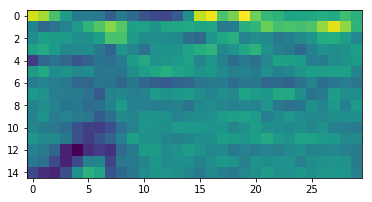

In [18]:
plt.imshow(trainPt['kw0Feat'][7])
plt.show()

## Salvar dicionários

Finalmente, os dicionários são atualizados, agora com as _features_ para elaborar o _dataset_.
Salva os dicionários com as _features_ extraídas no **ExtractFeatures**. 

In [19]:
if not os.path.isdir(PATH_ExtFeatdicts):
    os.makedirs(PATH_ExtFeatdicts)

np.save(os.path.join(PATH_ExtFeatdicts, 'trainPt.npy'), trainPt)
print('escrito: '+'trainPtSet.npy')
np.save(os.path.join(PATH_ExtFeatdicts, 'testPt.npy'),  testPt)
print('escrito: '+'testPtSet.npy')
np.save(os.path.join(PATH_ExtFeatdicts, 'validPt.npy'),  validPt)
print('escrito: '+'validPtSet.npy')
np.save(os.path.join(PATH_ExtFeatdicts, 'trainNoise.npy'), trainNoise)
print('escrito: '+'trainNoise.npy')
np.save(os.path.join(PATH_ExtFeatdicts, 'testNoise.npy'),  testNoise)
print('escrito: '+'testNoise.npy')
np.save(os.path.join(PATH_ExtFeatdicts, 'validNoise.npy'),  validNoise)
print('escrito: '+'validNoise.npy')

escrito: trainPtSet.npy
escrito: testPtSet.npy
escrito: validPtSet.npy
escrito: trainNoise.npy
escrito: testNoise.npy
escrito: validNoise.npy


### Clear all Variables

In [20]:
import sys
sys.modules[__name__].__dict__.clear()